In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
train = np.load('../dog-breed-identification/train.zip')

In [3]:
import glob
import random
import base64
import pandas as pd

from PIL import Image
from io import BytesIO
from IPython.display import HTML

def get_thumbnail(path):
    i = Image.open(path)
    i.resize((168, 168), Image.ANTIALIAS)
    #size = 1920,1080
    #im_resized = im.resize(size, Image.ANTIALIAS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

In [4]:
dogs = pd.read_csv('../dog-breed-identification/labels.csv')
#dogs = dogs.sample(50)
dogs['file'] = dogs.id.map(lambda id: f'/home/diegotakei/workspace/dog/dog-breed-identification/train/{id}.jpg')
dogs['image'] = dogs.file.map(lambda f: get_thumbnail(f))
dogs.head()

,id,breed,file,image
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,/home/diegotakei/workspace/dog/dog-breed-ident...,<PIL.JpegImagePlugin.JpegImageFile image mode=...
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,/home/diegotakei/workspace/dog/dog-breed-ident...,<PIL.JpegImagePlugin.JpegImageFile image mode=...
2,001cdf01b096e06d78e9e5112d419397,pekinese,/home/diegotakei/workspace/dog/dog-breed-ident...,<PIL.JpegImagePlugin.JpegImageFile image mode=...
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,/home/diegotakei/workspace/dog/dog-breed-ident...,<PIL.JpegImagePlugin.JpegImageFile image mode=...
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,/home/diegotakei/workspace/dog/dog-breed-ident...,<PIL.JpegImagePlugin.JpegImageFile image mode=...


In [5]:
dogs['Indexes'] = dogs["breed"].str.startswith('appenzeller')
    
result = dogs[(dogs.Indexes == True)]
result.tail()

,id,breed,file,image,Indexes
9683,f3b343a1d0a394e5d29a74f31f9922c8,appenzeller,/home/diegotakei/workspace/dog/dog-breed-ident...,<PIL.JpegImagePlugin.JpegImageFile image mode=...,True
9756,f59d3ddb3652e870bea7cb3b15894708,appenzeller,/home/diegotakei/workspace/dog/dog-breed-ident...,<PIL.JpegImagePlugin.JpegImageFile image mode=...,True
9932,f99cdde623294ec669ff9f2a31e17830,appenzeller,/home/diegotakei/workspace/dog/dog-breed-ident...,<PIL.JpegImagePlugin.JpegImageFile image mode=...,True
9957,fa1a19bd9f99b862cb0a986cbc0ea803,appenzeller,/home/diegotakei/workspace/dog/dog-breed-ident...,<PIL.JpegImagePlugin.JpegImageFile image mode=...,True
10193,ff4bb57ce419cd637dd511a1b5474bff,appenzeller,/home/diegotakei/workspace/dog/dog-breed-ident...,<PIL.JpegImagePlugin.JpegImageFile image mode=...,True


,breed,image
67,appenzeller,
78,appenzeller,
239,appenzeller,
256,appenzeller,
463,appenzeller,
650,appenzeller,
960,appenzeller,
1007,appenzeller,
1098,appenzeller,
1107,appenzeller,

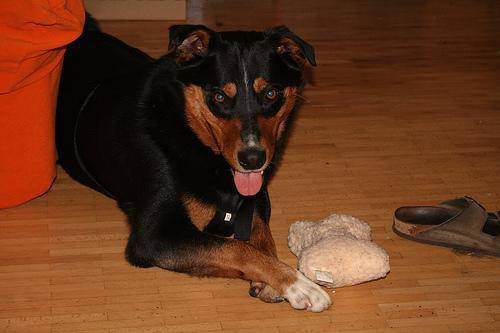
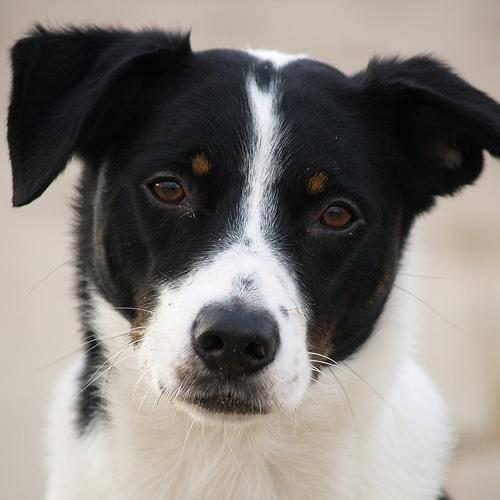
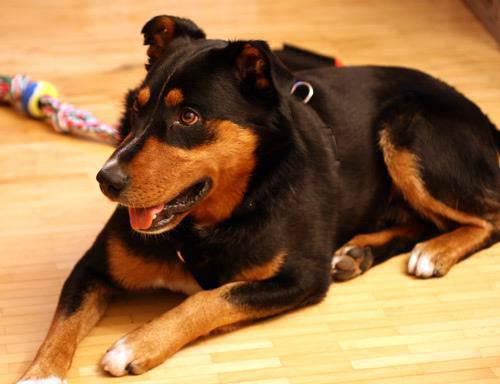
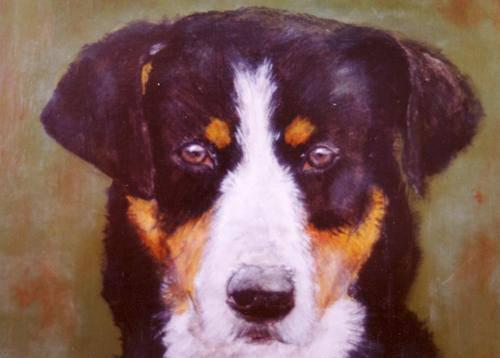
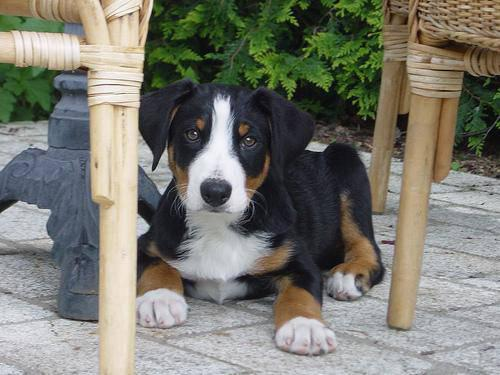
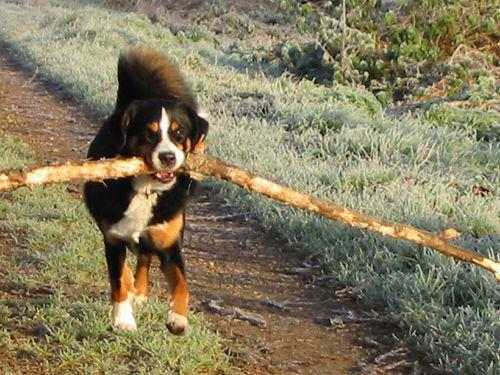
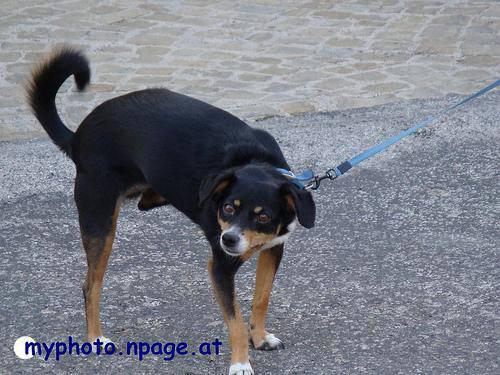
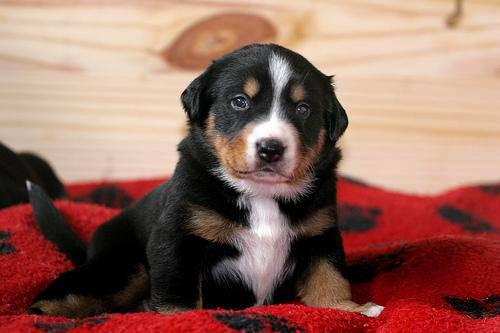
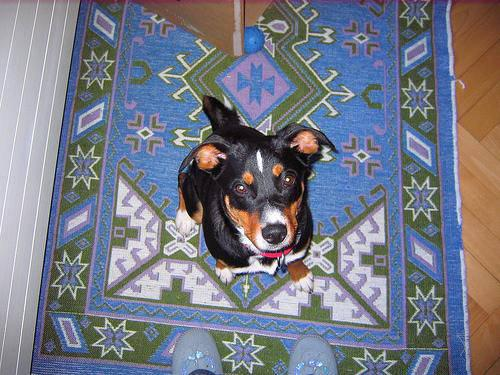
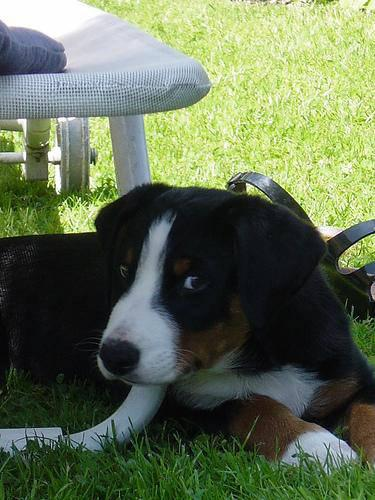
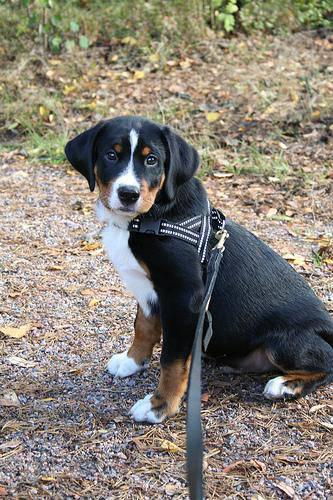
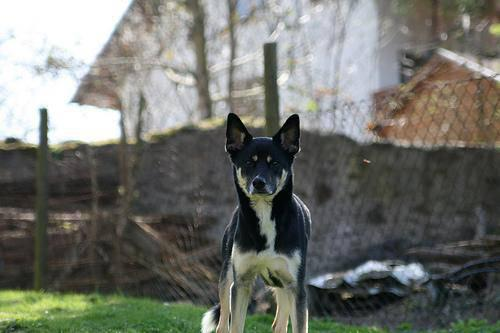
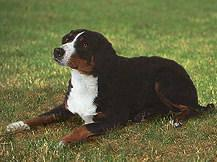
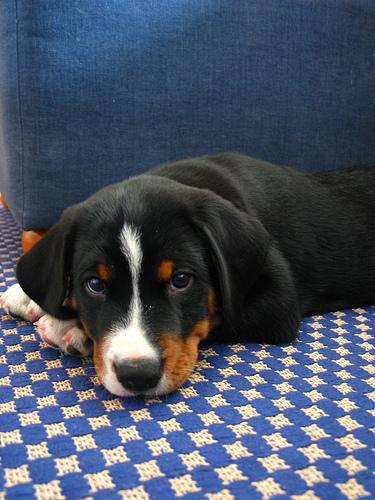
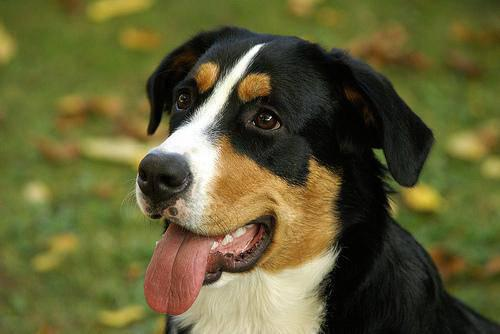
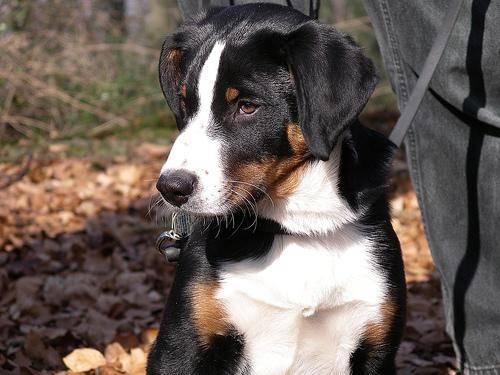
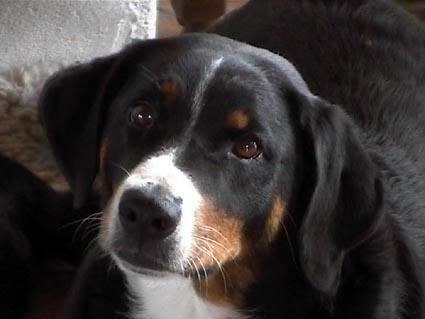
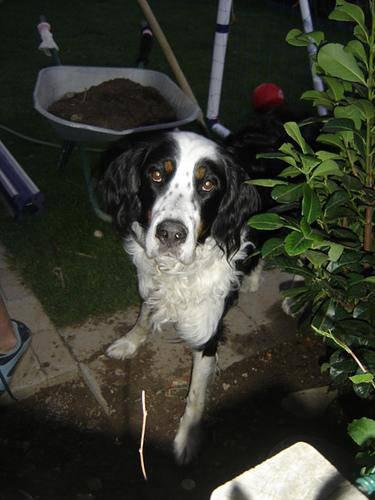
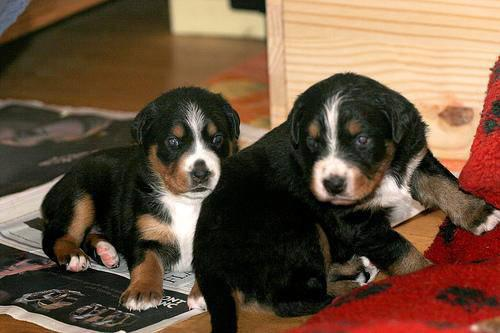
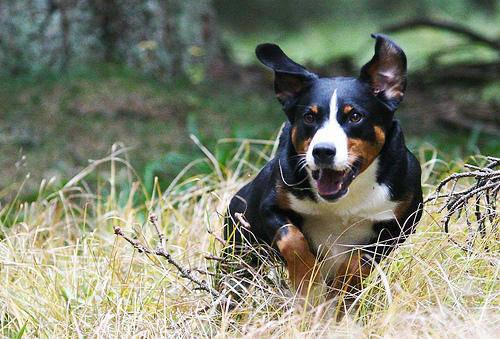
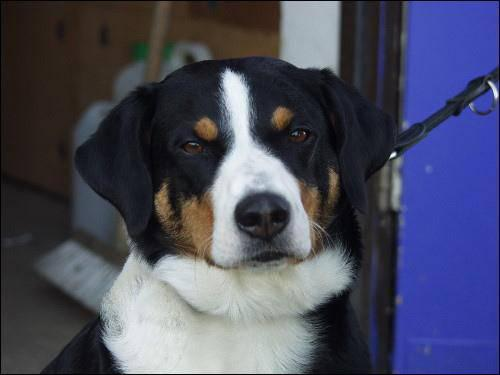
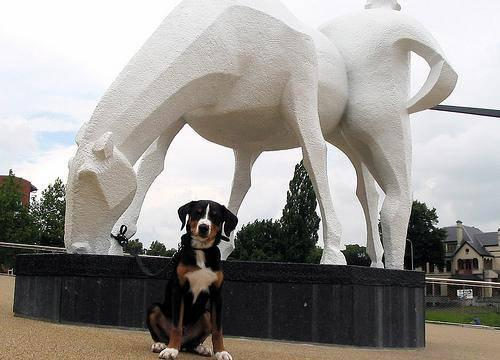
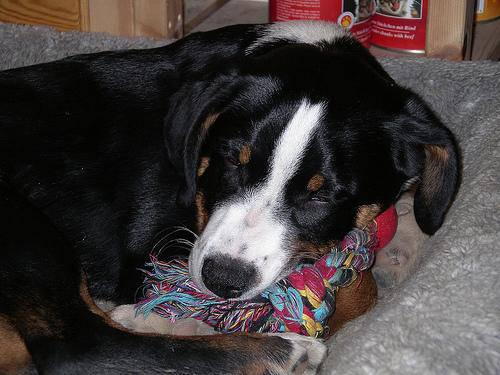
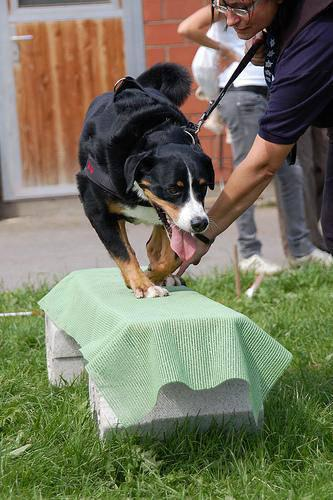
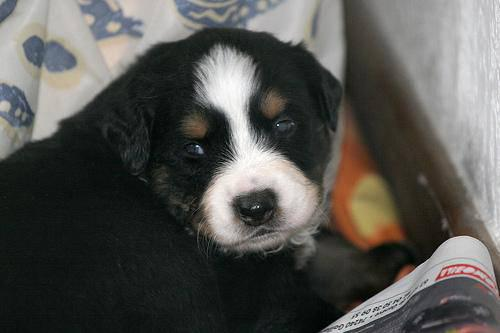
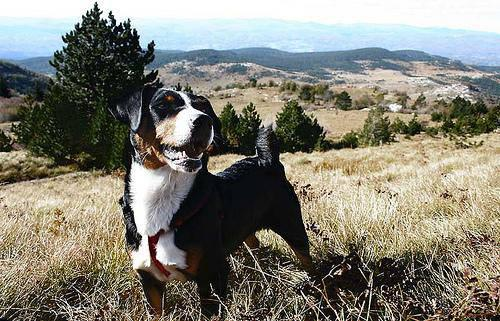
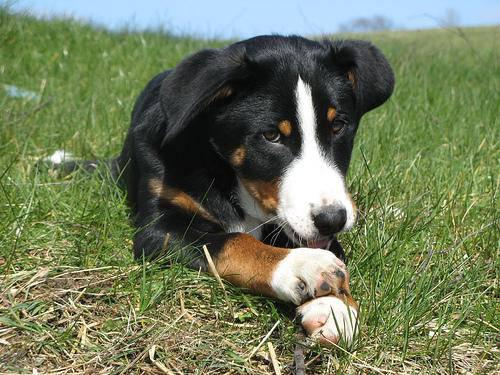
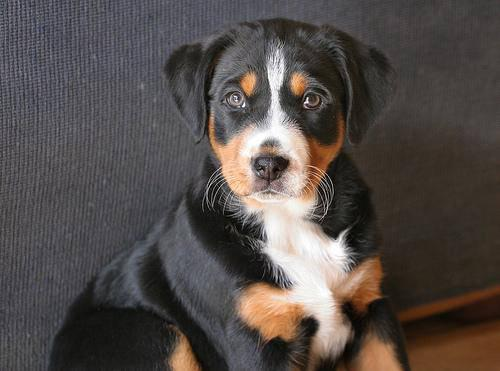
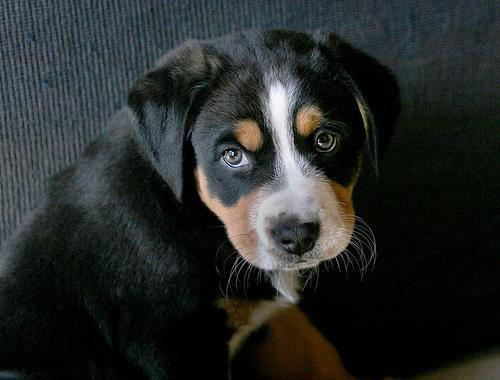
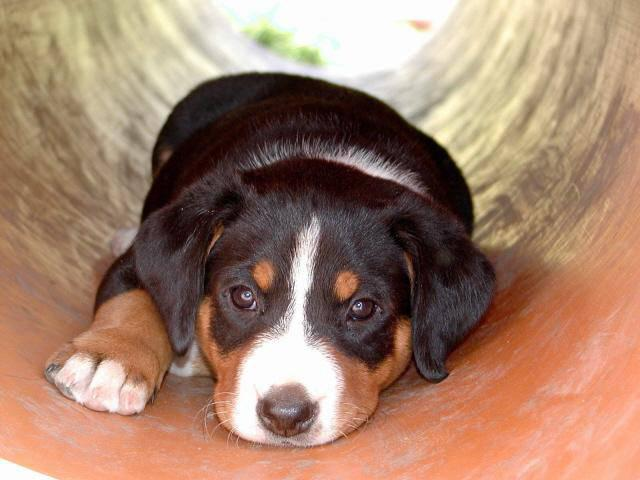
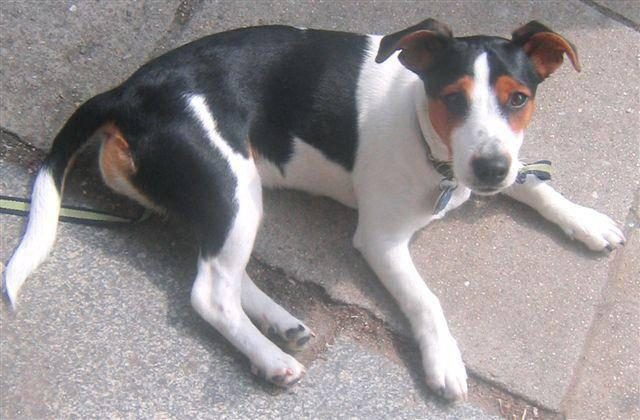
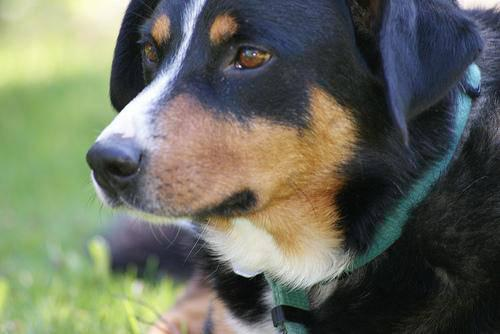
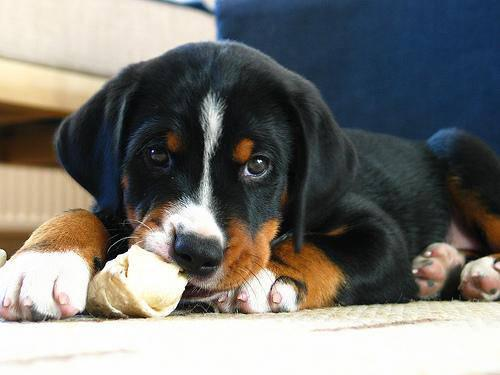
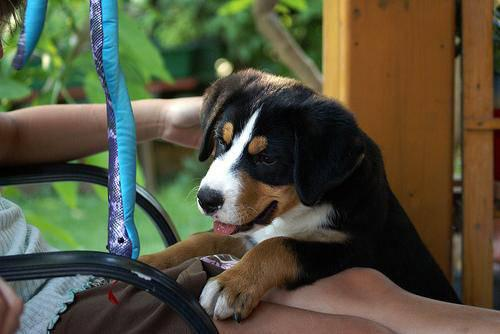
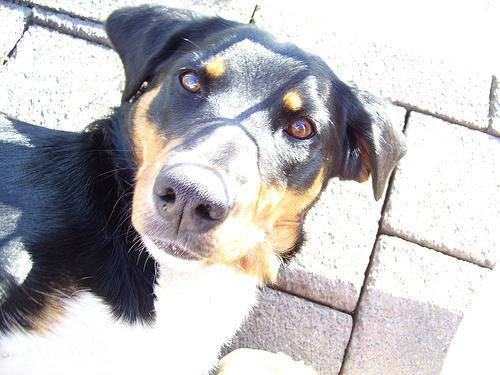
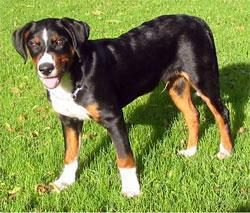
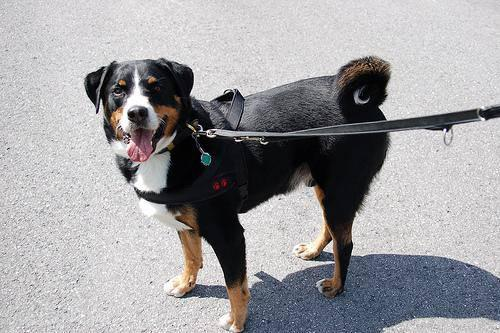
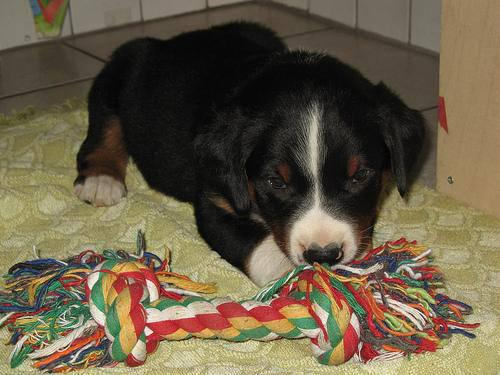
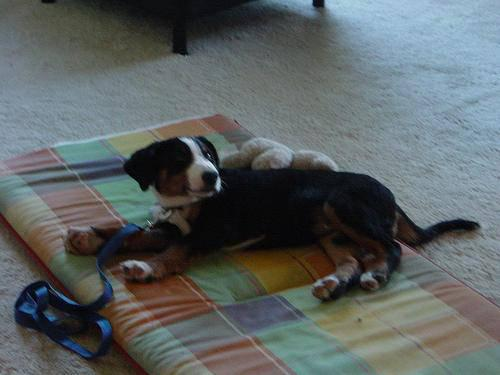
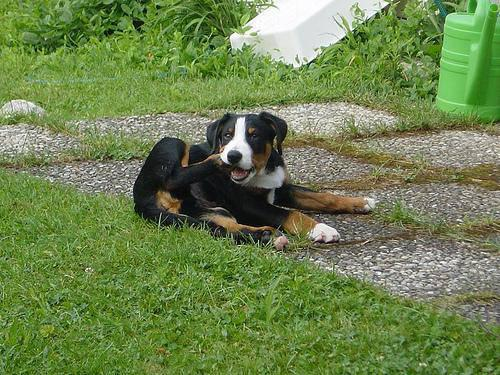
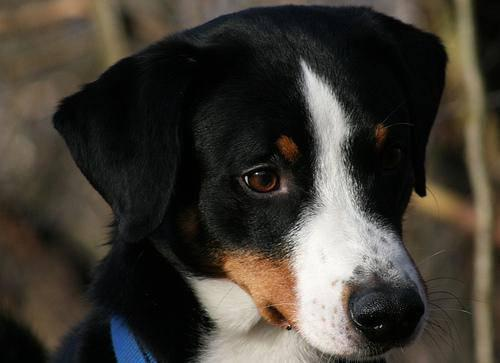
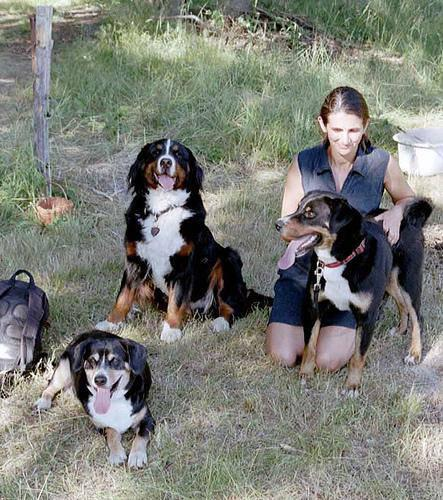
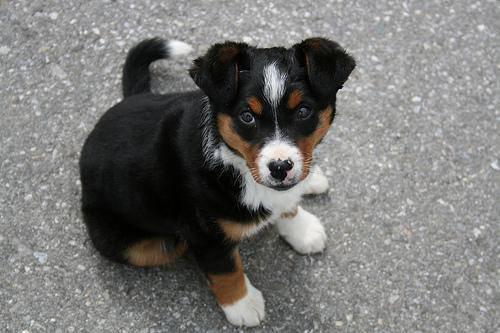
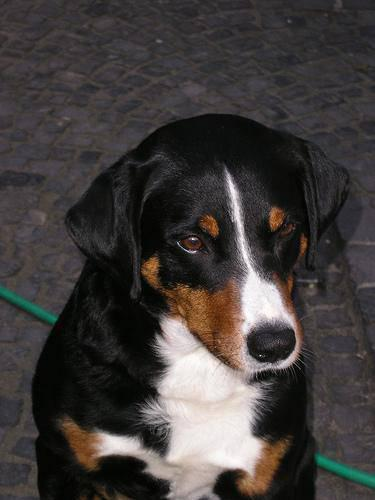
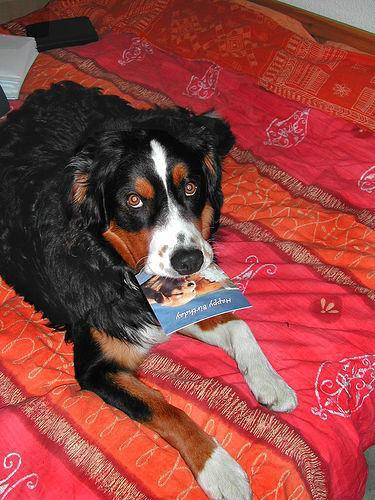
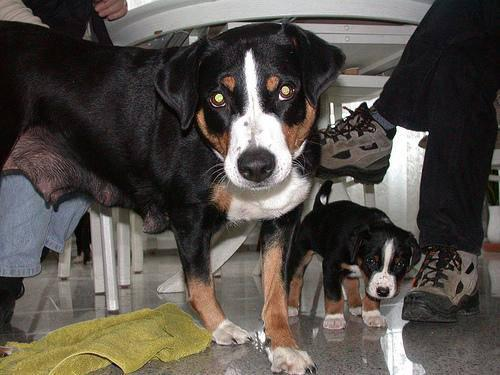
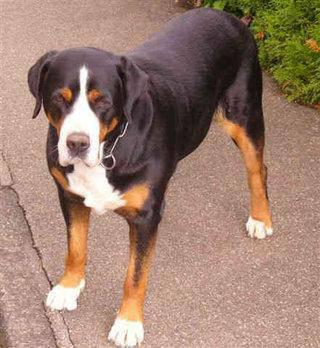
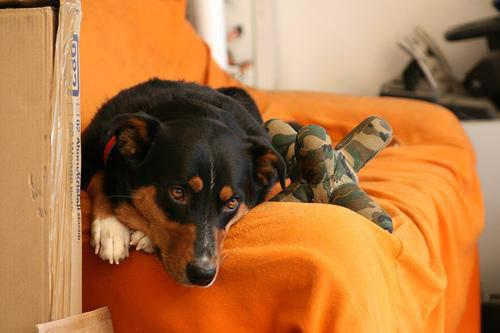
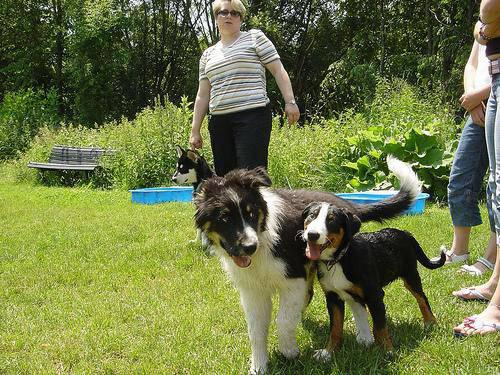
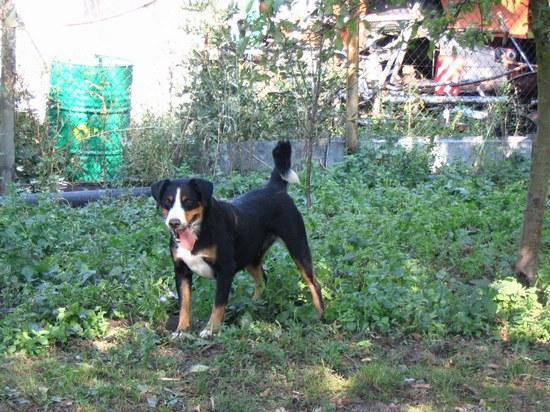
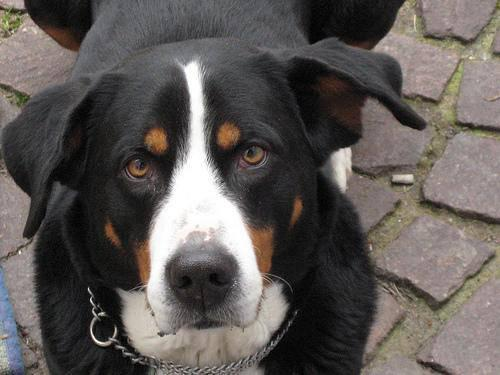
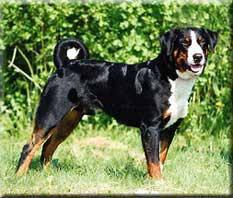
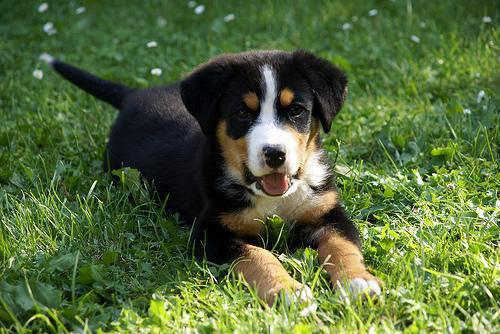
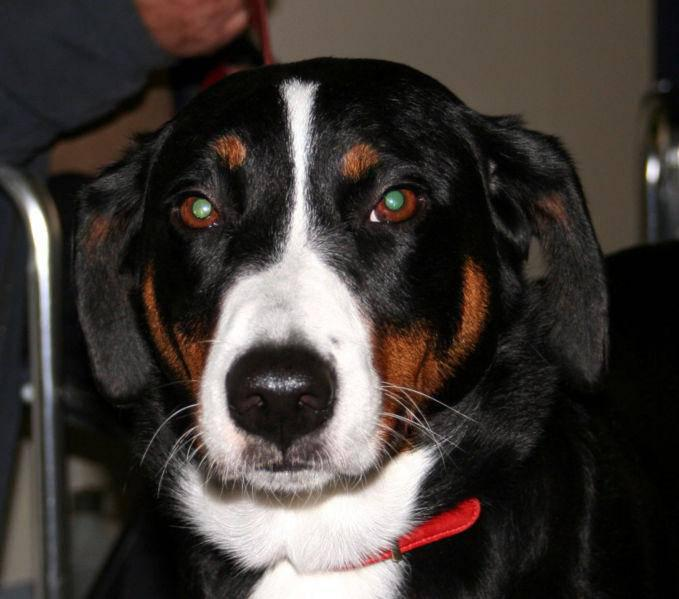
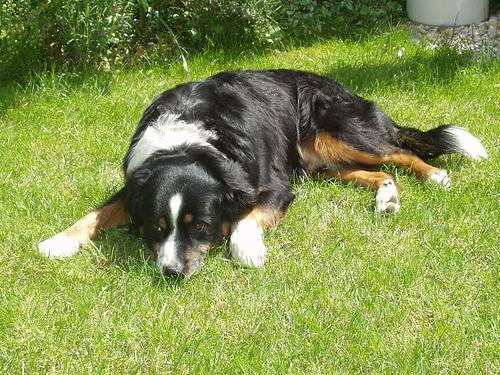
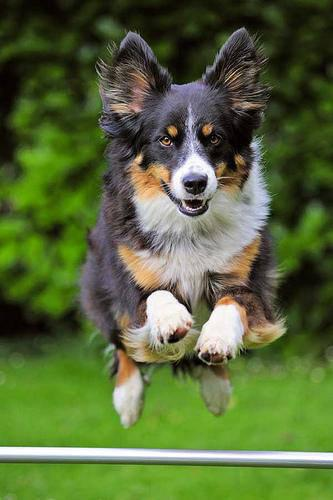
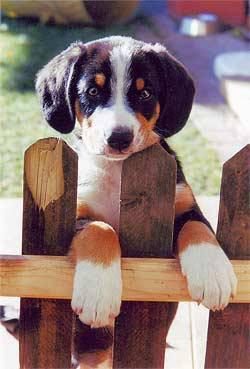
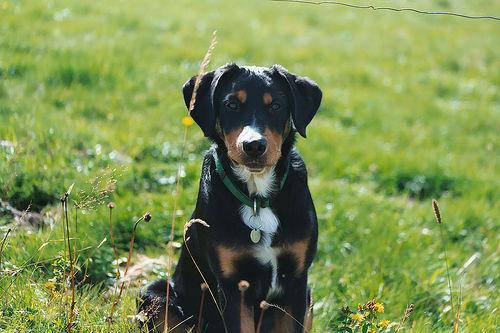
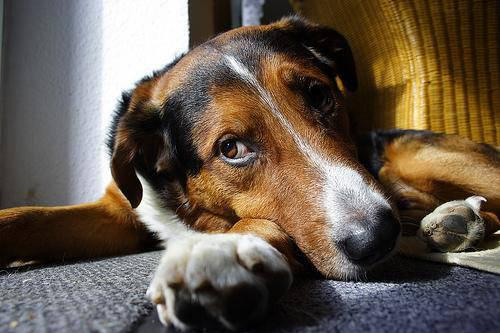
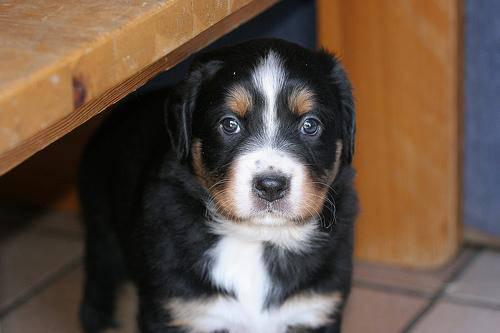
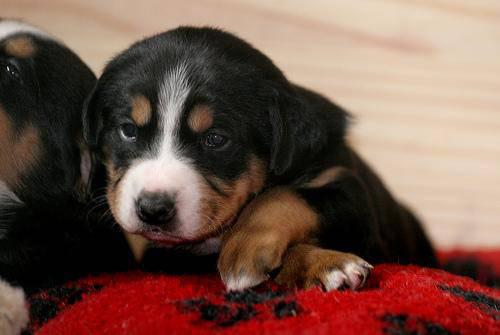
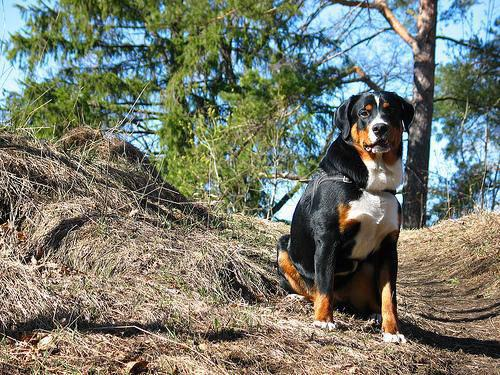
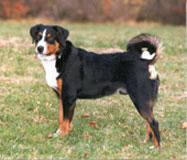
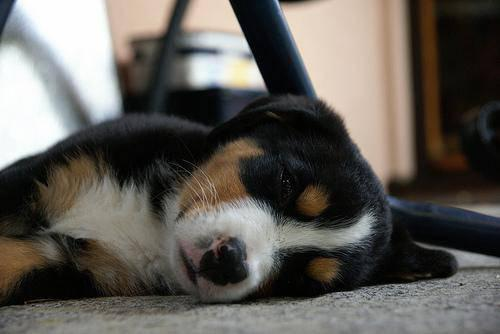
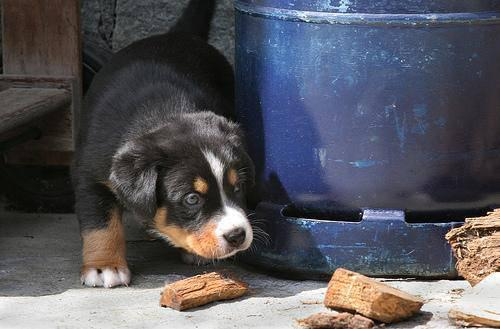
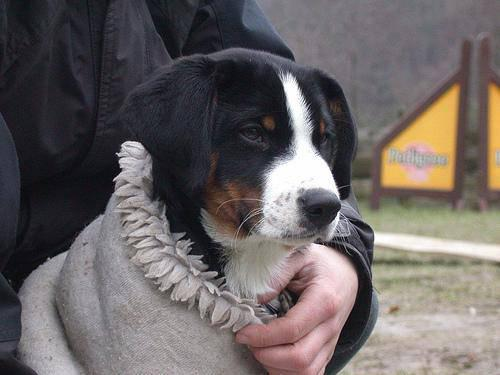
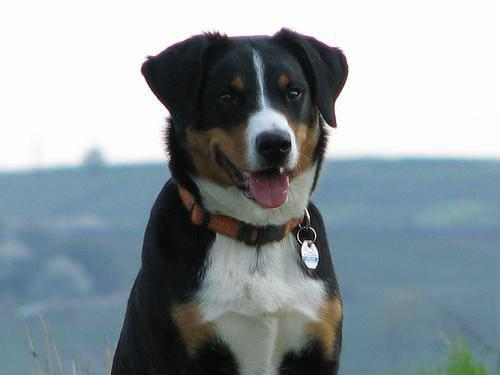
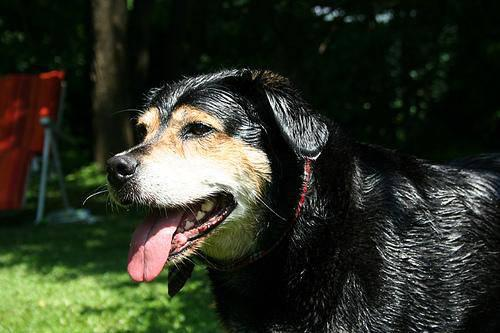
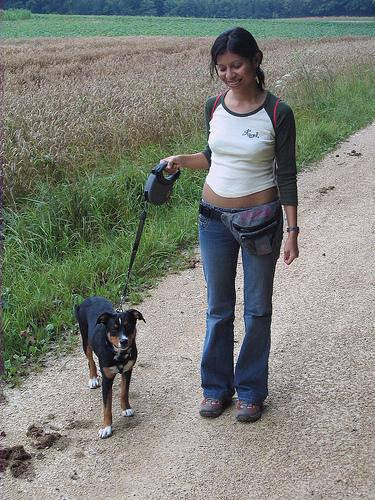
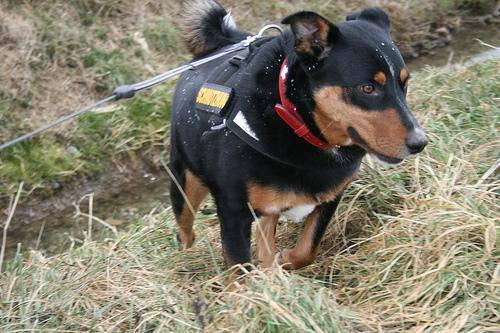
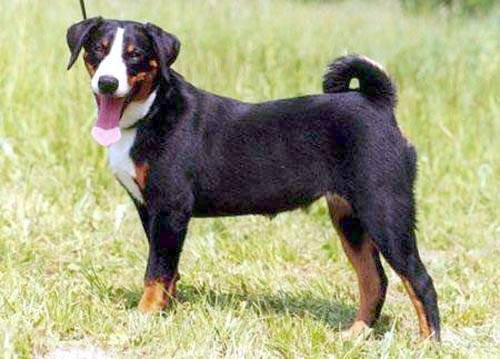
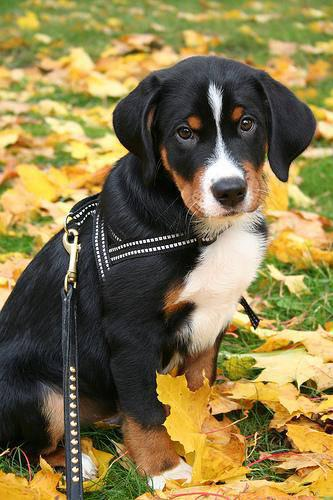
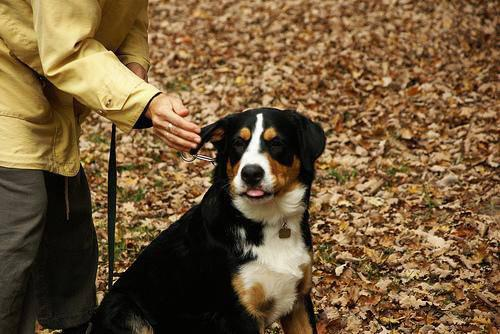
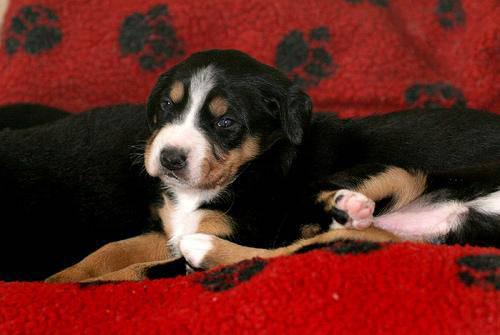
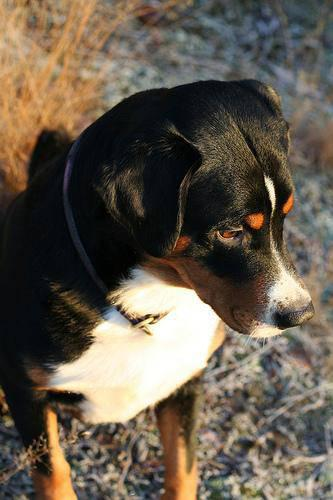
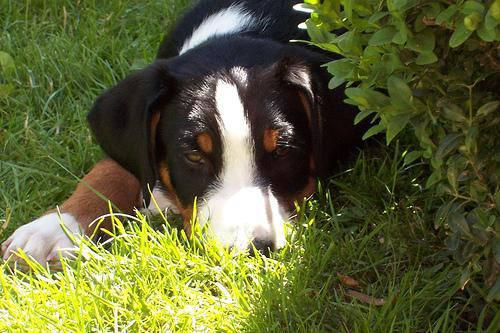
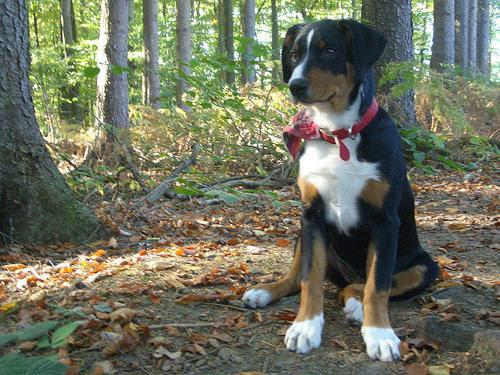
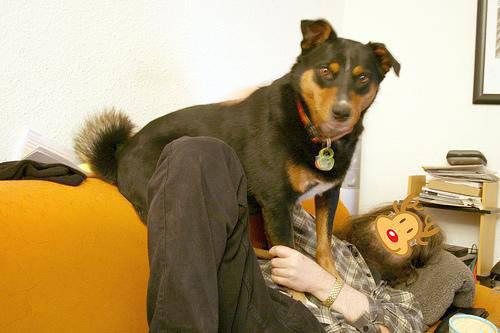

In [8]:
pd.set_option('display.max_colwidth', -1)
HTML(result[['breed', 'image']].to_html(formatters={'image': image_formatter}, escape=False))
#pd.reset_option('all')

In [9]:
train_images = dogs['image']

In [10]:
train_labels = dogs['breed']

In [6]:
def create_network(features, labels, mode):
    input = tf.reshape(features['x'], [-1, 28, 28, 1])
    
    # receives [batch_size, 28, 28, 1]
    # returns [batch_size, 28, 28, 32]
    convolution1 = tf.layers.conv2d(inputs = input, filters = 32, kernel_size = [5,5], activation = tf.nn.relu,
                                 padding = 'same')
    
    # receives [batch_size, 28, 28, 1]
    # returns [batch_size, 14, 14, 32]
    pooling1 = tf.layers.max_pooling2d(inputs = convolution1, pool_size = [2,2], strides = 2)
    
    # receives [batch_size, 14, 14, 32]
    # returns [batch_size, 14, 14, 64]
    convolution2 = tf.layers.conv2d(inputs = pooling1, filters = 64, kernel_size = [5,5], activation = tf.nn.relu,
                                  padding = 'same')
    
    # receives [batch_size, 14, 14, 64]
    # returns [batch_size, 7, 7, 64]
    pooling2 = tf.layers.max_pooling2d(inputs = convolution2, pool_size = [2,2], strides = 2)
    
    # receives [batch_size, 7, 7, 64]
    # returns [batch_size, 3136]
    flattening = tf.reshape(pooling2, [-1, 7 * 7 * 64])
    
    # 3136 inputs -> 1024 neurons on hidden layer -> 10 outputs
    # receives [batch_size, 3136]
    # returns [batch_size, 1024]
    dense = tf.layers.dense(inputs = flattening, units = 1024, activation = tf.nn.relu)
    
    dense2 = tf.layers.dense(inputs = dense, units = 1024, activation = tf.nn.relu)
    
    # dropout
    dropout =  tf.layers.dropout(inputs = dense2, rate = 0.2, training = mode == tf.estimator.ModeKeys.TRAIN)
    
    # receives [batch_size, 1024]
    # returns [batch_size, 10]
    output = tf.layers.dense(inputs = dropout, units = 10)
    
    predictions = tf.argmax(output, axis = 1)
    
    if(mode == tf.estimator.ModeKeys.PREDICT):
        return tf.estimator.EstimatorSpec(mode = mode, predictions = predictions)  
    
    losses = tf.losses.sparse_softmax_cross_entropy(labels = labels, logits = output)
    
    if(mode == tf.estimator.ModeKeys.TRAIN):
        optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
        train = optimizer.minimize(losses, global_step = tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode = mode, loss = losses, train_op = train)
    
    if(mode == tf.estimator.ModeKeys.EVAL):
        eval_metrics_ops = {'accuracy': tf.metrics.accuracy(labels = labels, predictions = predictions)}
        return tf.estimator.EstimatorSpec(mode = mode, loss = losses, eval_metric_ops = eval_metrics_ops) 

In [7]:
classifier = tf.estimator.Estimator(model_fn = create_network)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmppln3i8u7', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7eff0e97e7f0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
train_function = tf.estimator.inputs.numpy_input_fn(x = {'x': train_images}, y = train_labels, 
                                                        batch_size= 128, num_epochs= None, shuffle= True)
classifier.train(input_fn = train_function, steps = 2000)